# Example Neural Model Classification

## Imports, Functions, & Settings

In [76]:
from datasets import Dataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import cv2
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
import torch

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as tv_datasets
import torchvision.models as models

from PIL import Image as PIL_Image

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [3]:
# Define CNN Model
class NeuralDataExpert(nn.Module):
    def __init__(self):
        super(NeuralDataExpert, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, 2)  # Binary classification (Laughter vs. Non-Laughter)
        self.brain_modality_mean = [17.6743, 17.4406, 17.1653]
        self.brain_modality_std = [7.7531, 8.4884, 9.5815]
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
                transforms.Normalize(mean=self.brain_modality_mean, std=self.brain_modality_std)
        ])
    
    def forward(self, x):
        return self.model(x)

In [4]:
class SingleImageDataset(Dataset):
    def __init__(self, image_path, label, transform=None):
        """
        Args:
            image_path (str): Path to the image file.
            label (int): Label for the image.
            transform (callable, optional): Optional transform to be applied on the image.
        """
        self.image_path = image_path
        self.label = label
        self.transform = transform

        # Load image
        self.image = PIL_Image.open(self.image_path).convert("RGB")

    def __len__(self):
        # Since it's just one image, the dataset length is 1
        return 1

    def __getitem__(self, idx):
        # Apply transformation if provided
        if self.transform:
            image = self.transform(self.image)
        else:
            image = self.image

        label = torch.tensor(self.label, dtype=torch.long)  # Or float if needed
        return image, label


In [5]:
def load_torch_model(model_file_path, modelClass):
    """
    This will return the loaded model using the 
    file path. It will use cuda if available.

    Parameters
    ----------
    model_file_path : str
        This is the path of the stored pytorch model.
    model : nn.Module class
        This is the model definition used to define
        the model that is loaded.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = modelClass()
    model.load_state_dict(torch.load(model_file_path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))
    model = model.to(device)
    
    return model

In [75]:
# Save the model state_dict
def save_model(model, path):
    """
    This function will save the trained pytorch model.

    Parameters
    ----------
    model : str
        This is the trained pytorch model.
    path : str
        This is the location the model is to be saved.
    """
    torch.save(model.state_dict(), path)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
neural_data_model_f_path = '../models/neural_image_classifier_model.pth'
training_data = '../data/train/brain/'
testing_data = '../data/test/brain/'

In [8]:
neural_data_model = load_torch_model(neural_data_model_f_path, NeuralDataExpert)

/home/linux-pc/anaconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/linux-pc/anaconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Single Image Prediction

In [9]:
index = 0

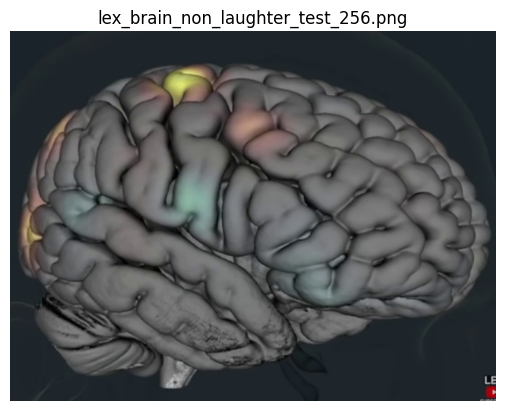

Predicted class: Laughter
Ground truth: Non-Laughter


In [120]:
# Testing the trained model on individual images
# Execute this cell everytime to make a prediction on a new image!

# Load and preprocess the image
test_image_path = glob('../data/test/brain/0_non-laughter/' + "*.png")

# image_path = "../data/lex-non-laughter.png"  # Path to your uploaded image
image_path  = test_image_path[index]

image = PIL_Image.open(image_path).convert("RGB")  # Ensure it's in RGB mode
plt.imshow(cv2.imread(image_path))
plt.title(f"{os.path.basename(image_path)}")
plt.axis('off')
plt.show()
index+=1 
index%=len(test_image_path)

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to a fixed size
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=neural_data_model.brain_modality_mean, std=neural_data_model.brain_modality_std)  # Normalize (if needed)
])

label = 0  # for example, 1 for 'Laughter', 0 for 'Non-Laughter'

# Create dataset
dataset = SingleImageDataset(image_path=image_path, label=label, transform=transform)

# Create DataLoader (batch_size=1 because it's a single image)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

# Assuming 'neural_data_model' is your model
neural_data_model.eval()

# Move model to the same device as the data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
neural_data_model.to(device)

# Iterate through the DataLoader
with torch.no_grad():
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = neural_data_model(images)
        _, predicted = torch.max(outputs, 1)
        prediction = predicted.item()

        # Print the result
        if prediction == 1:
            prediction_label = "Laughter"
        else:
            prediction_label = "Non-Laughter"
        print(f"Predicted class: {prediction_label}\nGround truth: Non-Laughter")


## Multi-Image Prediction

In [121]:
dataset = tv_datasets.ImageFolder(root='../data/test/brain/', transform=neural_data_model.transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False)
neural_data_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
_  = neural_data_model.to(device)
predictions = []
total = 0
correct = 0
all_labels = []
with torch.no_grad():
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        all_labels.append(labels.cpu().numpy())
        # Forward pass
        
        
        outputs = neural_data_model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.append(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

all_labels = np.concatenate(all_labels, axis=0)
predictions = np.concatenate(predictions, axis=0)


Test Accuracy: 78.19%


### Metrics

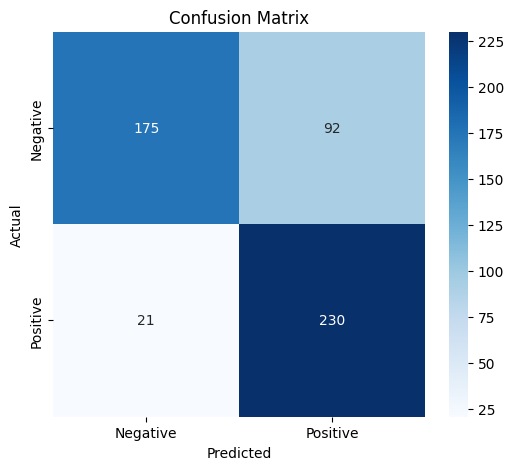

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.66      0.76       267
           1       0.71      0.92      0.80       251

    accuracy                           0.78       518
   macro avg       0.80      0.79      0.78       518
weighted avg       0.81      0.78      0.78       518


Other Metrics:
Accuracy: 0.7819
Precision: 0.7143
Recall: 0.9163
F1-Score: 0.8028
ROC AUC: 0.7859


In [122]:
y_true = all_labels  # True labels
y_pred = predictions  # Predicted labels

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate classification report (includes precision, recall, f1-score, support)
report = classification_report(y_true, y_pred)

# Calculate other metrics (if needed)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Print classification report and other metrics
print("Classification Report:")
print(report)

print("\nOther Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


### Training the Neural Network

In [66]:
# Computing the Mean and Variance to Normalize the data:

# Load your dataset
dataset = tv_datasets.ImageFolder(root=training_data, transform=transforms.ToTensor())

# Create a DataLoader to iterate over the dataset
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

# Initialize variables to compute the mean and std
brain_modality_mean = 0.0
brain_modality_std = 0.0
num_batches = 0

# Iterate over the dataset to compute mean and std
for images, _ in dataloader:
    batch_samples = images.size(0)  # Get the number of images in the batch
    images = images.view(batch_samples, images.size(1), -1)  # Flatten the images
    brain_modality_mean += images.mean(2).sum(0)  # Sum the mean of each image channel
    brain_modality_std += images.std(2).sum(0)    # Sum the std of each image channel
    num_batches += 1

brain_modality_mean /= num_batches  # Average mean over all batches
brain_modality_std /= num_batches    # Average std over all batches

print("Mean:", brain_modality_mean)
print("Std:", brain_modality_std)


Mean: tensor([17.6743, 17.4406, 17.1653])
Std: tensor([7.7531, 8.4884, 9.5815])


In [67]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match model input size
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=brain_modality_mean, std=brain_modality_std)  # Normalize pixel values
])


In [68]:
# Initialize model
neuralModel = NeuralDataExpert().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(neuralModel.parameters(), lr=0.001)

/home/linux-pc/anaconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/linux-pc/anaconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [69]:
# Load dataset (Assuming laughter and non-laughter images are in separate folders)
neuralModel = NeuralDataExpert().to(device)
dataset = tv_datasets.ImageFolder(root=training_data, transform=neuralModel.transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [70]:
# Training loop
epochs = 10
for epoch in tqdm(range(epochs), desc="Training...", ascii="░▒▓█"):
    neuralModel.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = neuralModel(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")


Training...:  10%|█░░░░░░░░░| 1/10 [00:09<01:28,  9.83s/it]

Epoch [1/10], Loss: 0.6275


Training...:  20%|██░░░░░░░░| 2/10 [00:18<01:13,  9.24s/it]

Epoch [2/10], Loss: 0.6269


Training...:  30%|███░░░░░░░| 3/10 [00:27<01:03,  9.02s/it]

Epoch [3/10], Loss: 0.6296


Training...:  40%|████░░░░░░| 4/10 [00:36<00:54,  9.01s/it]

Epoch [4/10], Loss: 0.6230


Training...:  50%|█████░░░░░| 5/10 [00:45<00:44,  8.93s/it]

Epoch [5/10], Loss: 0.6251


Training...:  60%|██████░░░░| 6/10 [00:54<00:35,  8.94s/it]

Epoch [6/10], Loss: 0.6246


Training...:  70%|███████░░░| 7/10 [01:02<00:26,  8.91s/it]

Epoch [7/10], Loss: 0.6255


Training...:  80%|████████░░| 8/10 [01:12<00:17,  8.98s/it]

Epoch [8/10], Loss: 0.6234


Training...:  90%|█████████░| 9/10 [01:21<00:09,  9.01s/it]

Epoch [9/10], Loss: 0.6241


Training...: 100%|██████████| 10/10 [01:30<00:00,  9.01s/it]

Epoch [10/10], Loss: 0.6253


In [71]:
# Evaluation
neuralModel.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = neuralModel(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")

Validation Accuracy: 62.10%


In [123]:
# Save the model for future use
save_model(neuralModel, "../models/neural_image_classifier_model.pth")